In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('fivethirtyeight')

import pymongo

In [2]:
try:
    conn=pymongo.MongoClient()
    print ("Connected successfully!!!")
except pymongo.errors.ConnectionFailure as e:
    print ("Could not connect to MongoDB: {}s".format(e)) 
conn

Connected successfully!!!


MongoClient(host=['localhost:27017'], document_class=dict, tz_aware=False, connect=True)

In [3]:
vscode = conn.vscode
vs = vscode.Issues

In [4]:
user_dict = {}

for cursor in vs.find():
    unlabels = []
    issue_number = cursor["number"]
    date_created = cursor["created_at"]
    if "labeled" in cursor:
        labels = cursor["labeled"]
    if "unlabeled" in cursor:
        unlabels = cursor["unlabeled"]       
    date_closed = 0
    if "status" in cursor: 
        if cursor["status"][-1][0] == "closed":
            date_closed = cursor["status"][-1][1]
    if "assigned" in cursor:
        for user in cursor["assigned"]:
            user_number = user[0]
            date_assigned = user[1]
            date_unassigned = 0
            if "unassigned" in cursor:
                for unassigned_user in cursor["unassigned"]:
                    if unassigned_user[0] == user_number:
                        date_unassigned = unassigned_user[1]
            
            if user_number not in user_dict:
                user_dict[user_number] = {}
                user_dict[user_number][issue_number] = {"assigned":date_assigned, "unassigned": date_unassigned,
                                  "labels":labels, "date_closed": date_closed, "date_opened": date_created,
                                    "unlabeded": unlabels}
                
                
            else:
                user_dict[user_number][issue_number] = {"assigned":date_assigned, "unassigned": date_unassigned,
                                  "labels":labels, "date_closed": date_closed, "date_opened": date_created,
                                    "unlabeded": unlabels}       

In [5]:
def duplicate_label(x):
    if x is np.nan:
        return 0
    elif "*duplicate" in x or "duplicate" in x:
        return 1
    else: return 0

In [6]:
def create_df(user):
    #     create dataframe for the user
    df = pd.DataFrame.from_dict(user_dict[str(user)], orient='index')
    df.reset_index(inplace=True)
#     convert to datetime
    df["assigned_date"] = pd.to_datetime(df['assigned'])
    df["open_date"] = pd.to_datetime(df['date_opened'])
    df["close_date"] = pd.to_datetime(df['date_closed'])
    df["unassigned_date"] = pd.to_datetime(df['unassigned'])
    
    #     remove duplicate issues:
    df["duplicated"] = df["labels"].apply(duplicate_label)
    df = df[df["duplicated"] == 0]
    
    #     Hours the issue was open and time the user was assigned
#     current date, date when the data was downloaded
    current_date = pd.to_datetime("2018-06-25")
    df["time_open"] = df.apply(lambda row: row["close_date"] - row["open_date"] if row["date_closed"] != 0 
                           else current_date - row["open_date"], axis=1)
    df["hours_open"] = df["time_open"].apply(lambda x: x.total_seconds()/3600)
    
    df["time_assigned"] = df.apply(lambda row: row["unassigned_date"] - row["assigned_date"] if 
                        ((row["unassigned"] !=0) & (row["unassigned_date"] < row["close_date"]))  
                        else (row["close_date"] - row["assigned_date"] if 
                        row["date_closed"] != 0 else current_date - row["assigned_date"]), axis=1)
    df["hours_assigned"] = df["time_assigned"].apply(lambda x: x.total_seconds()/3600 if x>pd.to_timedelta('2s') else 0)
    
#     its closed by the user if:
#         its closed and never unassigned 
#         it was closed before the user being reassigned
    df["closed_by_user"] = df.apply(lambda row: 1 if ((row["unassigned"] == 0) & (row["date_closed"] != 0)) else 
                                    (0 if row["date_closed"] == 0 else
                                    (1 if row["close_date"] < row["unassigned_date"] else 0)), axis=1)

    return df             

In [7]:
def extract_metrics(df):
#     calculate metrics from the dataframe and return dictionary with the metrics
    assigned = df.shape[0]
    if assigned == 0:
        dictionary = {"assigned": 0, "closed": 0, "opens":0, "opens_assigned":0, "avg_open_hours": 0, 
                "oldest_assignment":pd.to_datetime("2000"), "reassignments": 0, "closed_user": 0,
                "last_closed": pd.to_datetime("2000"), "close_rate":0, "days_close_everything":0}        
        
        return dictionary
    
    closed = sum(df["date_closed"] != 0)
    
    opens = sum((df["date_closed"] == 0))
    opens_assigned = sum((df["date_closed"] == 0) & (df["unassigned"] == 0))
    avg_open_hours = df["hours_open"].mean()
    avg_open_hours_open = df[df["date_closed"] == 0]["hours_open"].mean()
    avg_open_hours_closed = df[df["date_closed"] != 0]["hours_open"].mean()
    avg_assign_hours = df["hours_assigned"].mean()
    avg_assign_hours_open = df[df["date_closed"] == 0]["hours_assigned"].mean()
    avg_assign_hours_closed = df[df["date_closed"] != 0]["hours_assigned"].mean()
    oldest_assignment = min(df["assigned_date"])
    reassignments = sum(df["unassigned"] != 0)
    reassignments_rate = reassignments/assigned*100
    closed_user = sum(df["closed_by_user"] == 1)
    closed_user_rate = closed_user / assigned*100
    
    if closed_user == 0:
        last_closed = pd.to_datetime("2000")
        close_rate = 0
        days_close_everything = 9999
    
    else:     
        last_closed = max(df[df["closed_by_user"] == 1]["close_date"]) 
#         if it took zero days to close the issues will give us division by zero error
        try:
            close_rate = closed_user / (last_closed - oldest_assignment).days
        except ZeroDivisionError:
            close_rate = closed_user
            
        days_close_everything = opens_assigned/close_rate
    
    dictionary = {"assigned": assigned, "closed": closed, "opens":opens, "opens_assigned":opens_assigned, 
                  "avg_open_hours": avg_open_hours, "reassignments%": reassignments_rate,
                "oldest_assignment":oldest_assignment, "reassignments": reassignments, "closed_user": closed_user,
                "last_closed": last_closed, "close_rate":close_rate, "days_close_everything":days_close_everything,
                 "avg_open_hours_open": avg_open_hours_open, "avg_open_hours_closed": avg_open_hours_closed, 
                 "avg_assign_hours": avg_assign_hours, "avg_assign_hours_open":avg_assign_hours_open, 
                  "avg_assign_hours_closed":avg_assign_hours_closed, "closed_user%":closed_user_rate}
                
    return dictionary 
        

In [8]:
def label_metrics(df, label):
#     calculate and extract metrics for specified label
    df[label] = df["labels"].apply(lambda x: 1 if label in x else 0)
    df2 = df[df[label] == 1]
    
    return extract_metrics(df2)

## Create dataframes with the metrics for users with more than 100 issues assigned to them

In [9]:
# users with more than 100 issues assigned to them
users = []
for user in user_dict.keys():
    if len(user_dict[user]) > 100:
        users.append(user)

In [10]:
# dataframe for first user
df = create_df(users[0])
metrics = extract_metrics(df)
df_metrics = pd.DataFrame(metrics, index=[users[0]])

### Using only some labels:

In [11]:
# label metrics for first user
bug_metrics = label_metrics(df, "bug")
bug_df = pd.DataFrame(bug_metrics, index=[users[0]])

verified_metrics = label_metrics(df, "verified")
verified_df = pd.DataFrame(verified_metrics, index=[users[0]])

needsinfo_metrics = label_metrics(df, "needs more info")
needsinfo_df = pd.DataFrame(needsinfo_metrics, index=[users[0]])

feature_metrics = label_metrics(df, "feature-request")
feature_df = pd.DataFrame(feature_metrics, index=[users[0]])

release_metrics = label_metrics(df, "new release")
release_df = pd.DataFrame(release_metrics, index=[users[0]])

debug_metrics = label_metrics(df, "debug")
debug_df = pd.DataFrame(debug_metrics, index=[users[0]])

workbench_metrics = label_metrics(df, "workbench")
workbench_df = pd.DataFrame(workbench_metrics, index=[users[0]])

editor_metrics = label_metrics(df, "editor")
editor_df = pd.DataFrame(editor_metrics, index=[users[0]])

upstream_metrics = label_metrics(df, "upstream")
upstream_df = pd.DataFrame(upstream_metrics, index=[users[0]])

question_metrics = label_metrics(df, "question")
question_df = pd.DataFrame(question_metrics, index=[users[0]])

javascript_metrics = label_metrics(df, "javascript")
javascript_df = pd.DataFrame(javascript_metrics, index=[users[0]])

In [12]:
for i in range(1, len(users)):
    df = create_df(users[i])
    metrics = extract_metrics(df)
    df_metr = pd.DataFrame(metrics, index=[users[i]])
    df_metrics = df_metrics.append(df_metr)
    
    bug_metrics = label_metrics(df, "bug")
    bug = pd.DataFrame(bug_metrics, index=[users[i]])
    bug_df = bug_df.append(bug)

    verified_metrics = label_metrics(df, "verified")
    verified = pd.DataFrame(verified_metrics, index=[users[i]])
    verified_df = verified_df.append(verified)

    needsinfo_metrics = label_metrics(df, "needs more info")
    needsinfo = pd.DataFrame(needsinfo_metrics, index=[users[i]])
    needsinfo_df = needsinfo_df.append(needsinfo)

    feature_metrics = label_metrics(df, "feature-request")
    feature = pd.DataFrame(feature_metrics, index=[users[i]])
    feature_df = feature_df.append(feature)

    release_metrics = label_metrics(df, "new release")
    release = pd.DataFrame(release_metrics, index=[users[i]])
    release_df = release_df.append(release)

    debug_metrics = label_metrics(df, "debug")
    debug = pd.DataFrame(debug_metrics, index=[users[i]])
    debug_df = debug_df.append(debug)

    workbench_metrics = label_metrics(df, "workbench")
    workbench = pd.DataFrame(workbench_metrics, index=[users[i]])
    workbench_df = workbench_df.append(workbench)

    editor_metrics = label_metrics(df, "editor")
    editor = pd.DataFrame(editor_metrics, index=[users[i]])
    editor_df = editor_df.append(editor)

    upstream_metrics = label_metrics(df, "upstream")
    upstream = pd.DataFrame(upstream_metrics, index=[users[i]])
    upstream_df = upstream_df.append(upstream)

    question_metrics = label_metrics(df, "question")
    question = pd.DataFrame(question_metrics, index=[users[i]])
    question_df = question_df.append(question)

    javascript_metrics = label_metrics(df, "javascript")
    javascript = pd.DataFrame(javascript_metrics, index=[users[i]])
    javascript_df = javascript_df.append(javascript)


In [13]:
df_metrics.head(15)

,assigned,avg_assign_hours,avg_assign_hours_closed,avg_assign_hours_open,avg_open_hours,avg_open_hours_closed,avg_open_hours_open,close_rate,closed,closed_user,closed_user%,days_close_everything,last_closed,oldest_assignment,opens,opens_assigned,reassignments,reassignments%
12821956,4035,686.429990,403.684855,4351.354824,1009.169462,715.136130,4820.411200,5.444444,3746,3479,86.220570,44.265306,2018-06-22 07:45:36,2016-09-20 22:34:16,289,241,327,8.104089
1898161,2115,1427.289205,702.948596,6174.307122,1713.184162,1015.035974,6288.548183,1.270526,1835,1207,57.068558,147.183099,2018-06-23 16:20:37,2015-11-16 15:23:24,280,187,799,37.777778
1926584,4214,812.326896,252.700124,5504.965646,1400.084757,863.878616,5896.334469,2.903260,3765,2761,65.519696,52.699384,2018-06-25 07:15:21,2015-11-16 15:11:39,449,153,1691,40.128144
16890566,914,648.361618,371.632989,3699.658878,954.720802,647.704652,4339.977825,0.997135,838,696,76.148796,49.140805,2018-06-25 08:17:09,2016-07-26 19:01:52,76,49,182,19.912473
22350,5199,1263.226447,615.027843,6665.269391,1589.320933,949.757413,6919.399676,4.009484,4642,3805,73.187151,62.102760,2018-06-22 06:50:51,2015-11-15 18:54:49,557,249,1384,26.620504
10746682,2364,1605.015621,680.812828,5535.958166,1886.703635,964.526571,5809.030081,1.971204,1914,1506,63.705584,164.366534,2018-06-21 08:44:34,2016-05-17 20:53:55,450,324,577,24.407783
6461412,3849,1187.698818,784.341186,6492.148268,1532.569448,1144.685014,6633.534972,3.197050,3577,3034,78.825669,53.486816,2018-06-22 15:25:11,2015-11-16 07:02:43,272,171,811,21.070408
323878,1826,1144.644787,566.457442,3886.489178,1475.536213,853.865169,4423.586320,1.884558,1508,1257,68.838992,132.126492,2018-06-24 06:13:58,2016-08-26 00:19:58,318,249,338,18.510405
900690,7162,1239.209361,391.285405,6803.990125,2002.162353,1225.531285,7099.060017,4.518868,6215,4311,60.192684,69.043841,2018-06-25 05:10:18,2015-11-13 16:48:18,947,312,2934,40.966211
9205389,990,1267.907168,699.739540,4028.058782,1518.284861,962.334409,4219.085575,0.890430,821,642,64.848485,163.965732,2018-06-22 15:26:02,2016-06-30 21:20:43,169,146,218,22.020202


In [14]:
bug_df.head(15)

,assigned,avg_assign_hours,avg_assign_hours_closed,avg_assign_hours_open,avg_open_hours,avg_open_hours_closed,avg_open_hours_open,close_rate,closed,closed_user,closed_user%,days_close_everything,last_closed,oldest_assignment,opens,opens_assigned,reassignments,reassignments%
12821956,774,1256.552935,716.161874,6010.626199,1691.234959,1112.337312,6784.068685,1.007825,695,644,83.204134,62.510870,2018-06-21 22:42:32,2016-09-20 22:38:10,79,63,74,9.560724
1898161,784,1620.655079,760.762905,8009.746392,1896.187419,1069.867884,8035.830418,0.498932,691,467,59.566327,150.321199,2018-06-12 23:04:18,2015-11-19 07:13:53,93,75,290,36.989796
1926584,1728,620.167919,251.146915,6627.829856,1076.867170,706.651962,7103.970764,1.329810,1628,1258,72.800926,27.823529,2018-06-22 15:38:23,2015-11-19 08:54:56,100,37,679,39.293981
16890566,294,649.451516,413.107271,4070.223494,961.478542,723.265890,4409.293246,0.390823,275,247,84.013605,17.910931,2018-06-22 21:57:41,2016-09-28 06:44:10,19,7,41,13.945578
22350,1930,1554.532080,1015.109091,5949.167709,1897.205172,1353.757089,6324.632919,1.492585,1719,1409,73.005181,94.466998,2018-06-20 13:55:52,2015-11-18 17:16:49,211,141,548,28.393782
10746682,858,1268.849778,597.004470,6193.541111,1543.965880,840.866948,6697.749310,0.812582,755,620,72.261072,89.837097,2018-06-20 18:15:53,2016-05-17 20:53:55,103,73,188,21.911422
6461412,1217,908.849826,695.623381,7183.037958,1277.929199,1069.715554,7404.615687,1.053968,1177,996,81.840592,18.027108,2018-06-21 08:25:23,2015-11-18 19:39:18,40,19,333,27.362366
323878,526,1287.923389,659.496701,4102.751262,1589.565540,915.472696,4608.939737,0.526237,430,351,66.730038,155.823362,2018-06-24 05:04:56,2016-08-26 00:19:58,96,82,97,18.441065
900690,2318,1353.171385,630.344895,8351.597442,1890.228491,1172.719059,8837.174652,1.620653,2101,1538,66.350302,79.597529,2018-06-20 08:13:17,2015-11-13 16:48:18,217,129,937,40.422778
9205389,310,1386.090427,651.892761,7993.869418,1758.764801,1025.075853,8361.965332,0.319444,279,230,74.193548,90.782609,2018-06-21 07:21:09,2016-06-30 21:20:43,31,29,57,18.387097


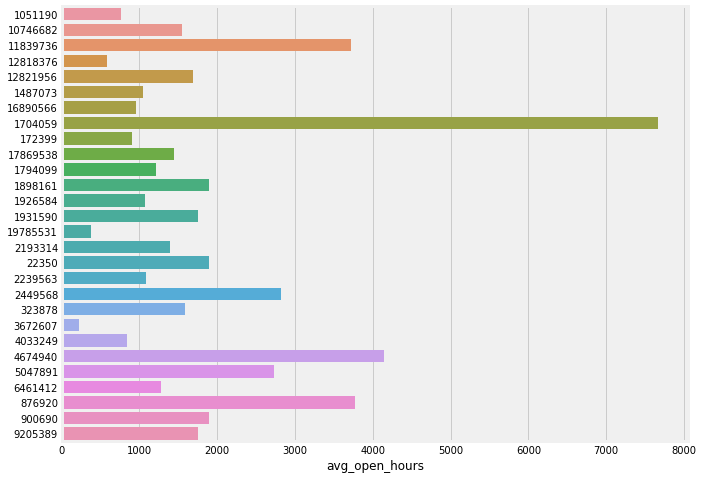

In [15]:
plt.figure(figsize=(10,8))
sns.barplot(y=bug_df.index, x="avg_assign_hours", data=bug_df, orient="h")
sns.barplot(y=bug_df.index, x="avg_open_hours", data=bug_df, orient="h")

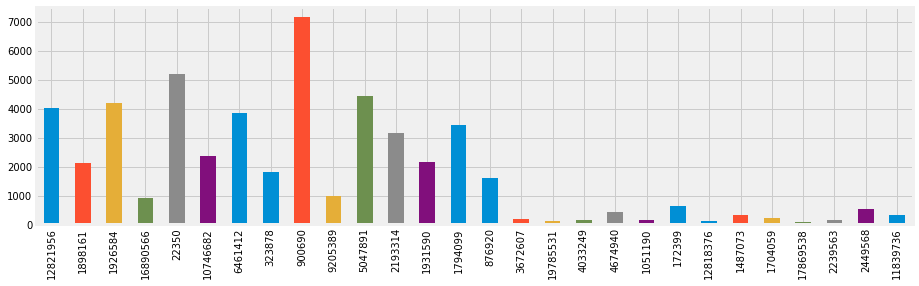

In [16]:
df_metrics["assigned"].plot.bar(figsize=(14,4));

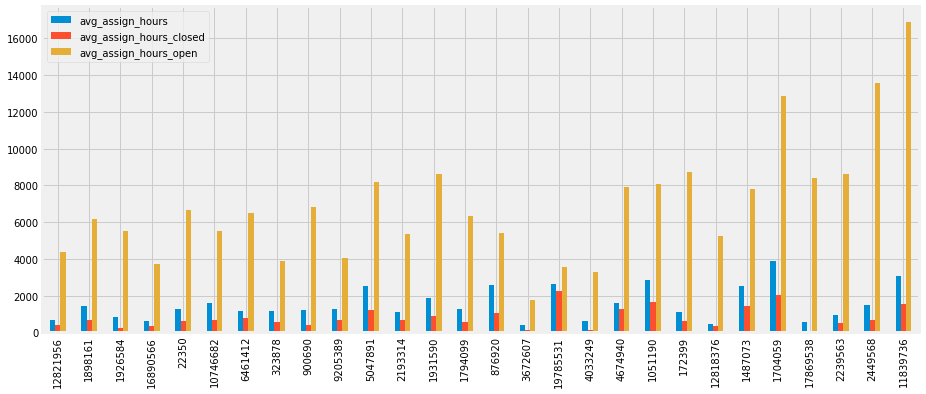

In [17]:
df_metrics[["avg_assign_hours", "avg_assign_hours_closed", "avg_assign_hours_open"]].plot.bar(figsize=(14,6));

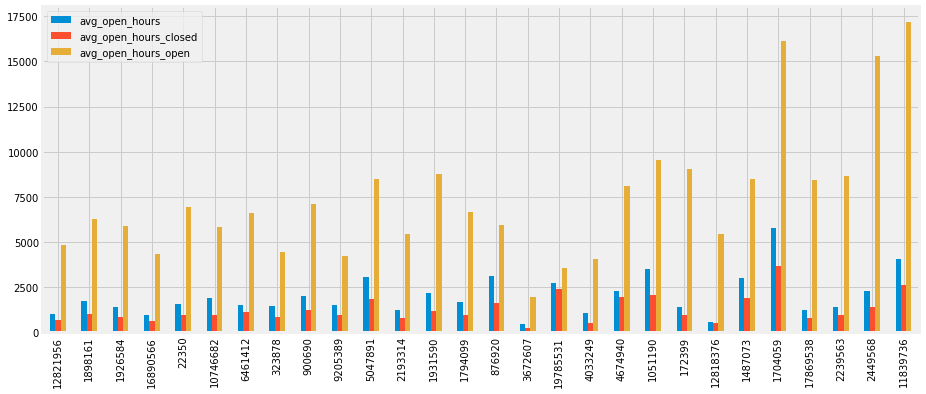

In [18]:
df_metrics[["avg_open_hours", "avg_open_hours_closed", "avg_open_hours_open"]].plot.bar(figsize=(14,6));

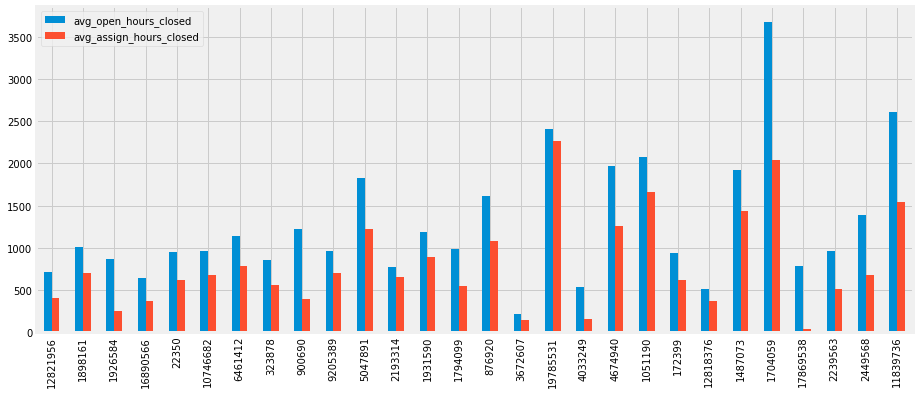

In [19]:
df_metrics[[ "avg_open_hours_closed", "avg_assign_hours_closed"]].plot.bar(figsize=(14,6));

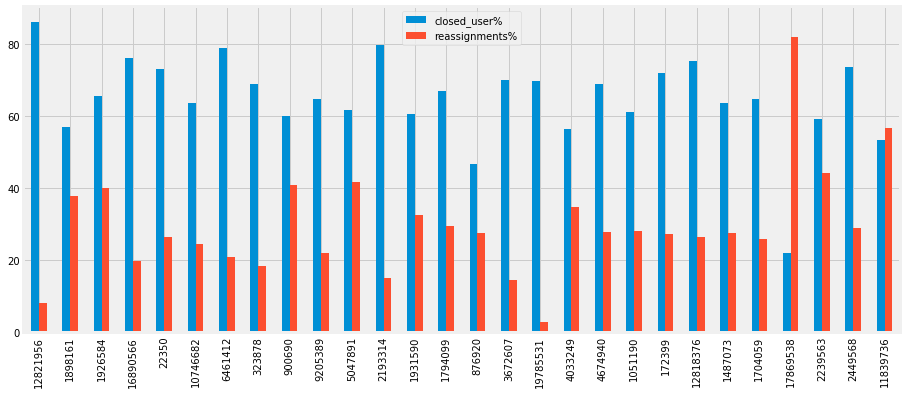

In [20]:
df_metrics[["closed_user%", "reassignments%"]].plot.bar(figsize=(14,6));

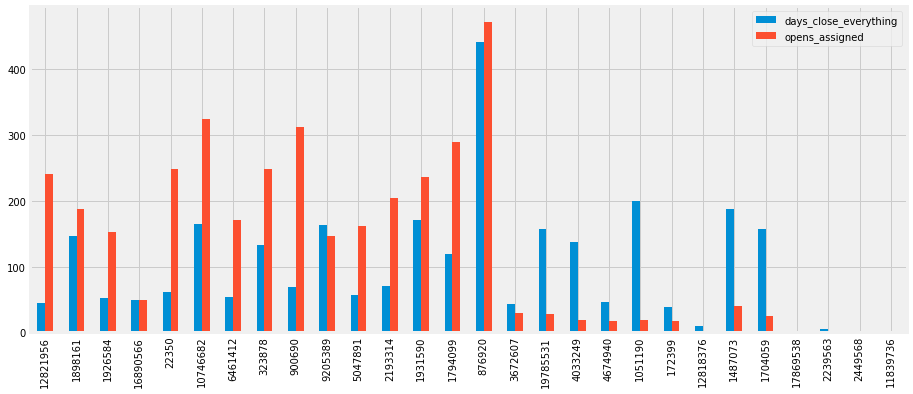

In [21]:
df_metrics[["days_close_everything", "opens_assigned"]].plot.bar(figsize=(14,6));

## Calculate % of total issues with the label were assigned to that user

In [22]:
df_metrics["assign_user_%"] = df_metrics["assigned"] / sum(df_metrics["assigned"])*100

bug_df["assign_user_%"] = bug_df["assigned"] / sum(bug_df["assigned"])*100
verified_df["assign_user_%"] = verified_df["assigned"] / sum(verified_df["assigned"])*100
needsinfo_df["assign_user_%"] = needsinfo_df["assigned"] / sum(needsinfo_df["assigned"])*100
feature_df["assign_user_%"] = feature_df["assigned"] / sum(feature_df["assigned"])*100
release_df["assign_user_%"] = release_df["assigned"] / sum(release_df["assigned"])*100
debug_df["assign_user_%"] = debug_df["assigned"] / sum(debug_df["assigned"])*100
workbench_df["assign_user_%"] = workbench_df["assigned"] / sum(workbench_df["assigned"])*100
editor_df["assign_user_%"] = editor_df["assigned"] / sum(editor_df["assigned"])*100
upstream_df["assign_user_%"] = upstream_df["assigned"] / sum(upstream_df["assigned"])*100
question_df["assign_user_%"] = question_df["assigned"] / sum(question_df["assigned"])*100
javascript_df["assign_user_%"] = javascript_df["assigned"] / sum(javascript_df["assigned"])*100


## Renaming columns and merge all the dataframes

In [23]:
bug_colum = ["bug_" + column for column in bug_df.columns]
verified_colum = ["verified_" + column for column in verified_df.columns]
needsinfo_colum = ["needsinfo_" + column for column in needsinfo_df.columns]
feature_colum = ["feature_" + column for column in feature_df.columns]
release_colum = ["release_" + column for column in release_df.columns]
debug_colum = ["debug_" + column for column in debug_df.columns]
workbench_colum = ["workbench_" + column for column in workbench_df.columns]
editor_colum = ["editor_" + column for column in editor_df.columns]
upstream_colum = ["upstream_" + column for column in upstream_df.columns]
question_colum = ["question_" + column for column in question_df.columns]
javascript_colum = ["javascript_" + column for column in javascript_df.columns]

In [24]:
bug_df.columns = bug_colum
verified_df.columns = verified_colum
needsinfo_df.columns = needsinfo_colum
feature_df.columns = feature_colum
release_df.columns = release_colum
debug_df.columns = debug_colum
workbench_df.columns = workbench_colum
editor_df.columns = editor_colum
upstream_df.columns = upstream_colum
question_df.columns = question_colum
javascript_df.columns = javascript_colum


In [25]:
df_total = df_metrics.merge(bug_df, how="left", left_index=True, right_index=True)
df_total = df_total.merge(verified_df, how="left", left_index=True, right_index=True)
df_total = df_total.merge(needsinfo_df, how="left", left_index=True, right_index=True)
df_total = df_total.merge(feature_df, how="left", left_index=True, right_index=True)
df_total = df_total.merge(release_df, how="left", left_index=True, right_index=True)
df_total = df_total.merge(debug_df, how="left", left_index=True, right_index=True)
df_total = df_total.merge(workbench_df, how="left", left_index=True, right_index=True)
df_total = df_total.merge(editor_df, how="left", left_index=True, right_index=True)
df_total = df_total.merge(upstream_df, how="left", left_index=True, right_index=True)
df_total = df_total.merge(question_df, how="left", left_index=True, right_index=True)
df_total = df_total.merge(javascript_df, how="left", left_index=True, right_index=True)


In [26]:
df_total.sort_values(by="assigned", ascending=False).head(10)

,assigned,avg_assign_hours,avg_assign_hours_closed,avg_assign_hours_open,avg_open_hours,avg_open_hours_closed,avg_open_hours_open,close_rate,closed,closed_user,...,javascript_closed_user,javascript_closed_user%,javascript_days_close_everything,javascript_last_closed,javascript_oldest_assignment,javascript_opens,javascript_opens_assigned,javascript_reassignments,javascript_reassignments%,javascript_assign_user_%
900690,7162,1239.209361,391.285405,6803.990125,2002.162353,1225.531285,7099.060017,4.518868,6215,4311,...,36,63.157895,30.666667,2018-06-11 14:15:20,2016-12-05 22:59:02,2,2,21,36.842105,2.635229
22350,5199,1263.226447,615.027843,6665.269391,1589.320933,949.757413,6919.399676,4.009484,4642,3805,...,24,70.588235,0.000000,2018-06-12 09:34:51,2016-08-30 14:57:03,2,0,10,29.411765,1.571891
5047891,4436,2500.123161,1221.349126,8207.360972,3045.026848,1830.653274,8464.841911,2.865828,3624,2734,...,25,59.523810,50.880000,2018-05-29 07:58:53,2016-08-30 14:52:46,6,2,18,42.857143,1.941748
1926584,4214,812.326896,252.700124,5504.965646,1400.084757,863.878616,5896.334469,2.903260,3765,2761,...,8,66.666667,0.000000,2018-06-21 11:59:21,2017-01-13 20:57:56,1,0,4,33.333333,0.554785
12821956,4035,686.429990,403.684855,4351.354824,1009.169462,715.136130,4820.411200,5.444444,3746,3479,...,1430,88.985688,31.820979,2018-06-22 07:45:36,2016-11-22 07:48:10,93,79,101,6.285003,74.294961
6461412,3849,1187.698818,784.341186,6492.148268,1532.569448,1144.685014,6633.534972,3.197050,3577,3034,...,51,56.043956,129.019608,2018-06-22 15:25:11,2015-11-25 14:11:41,11,7,34,37.362637,4.207120
1794099,3454,1262.497496,545.741925,6316.543191,1685.813298,983.735693,6636.360511,2.427673,3025,2316,...,20,35.714286,221.250000,2018-04-27 07:41:22,2015-11-23 09:42:34,10,5,31,55.357143,2.588997
2193314,3177,1096.071939,655.970876,5379.623171,1213.430252,777.850472,5452.975341,2.910550,2881,2538,...,8,47.058824,0.000000,2018-03-22 18:15:29,2017-02-22 11:12:19,3,0,9,52.941176,0.785945
10746682,2364,1605.015621,680.812828,5535.958166,1886.703635,964.526571,5809.030081,1.971204,1914,1506,...,6,54.545455,167.000000,2018-06-11 15:00:21,2017-07-12 07:03:32,3,3,2,18.181818,0.508553
1931590,2158,1889.023674,895.712376,8606.380654,2165.883878,1188.497799,8775.545130,1.377497,1880,1310,...,4,28.571429,0.000000,2017-02-28 04:41:49,2016-03-01 08:14:58,0,0,11,78.571429,0.647249


## Check the number of issues by label assigned to a user 

In [27]:
assigned_cols = [column for column in df_total.columns if "_assigned" in column]

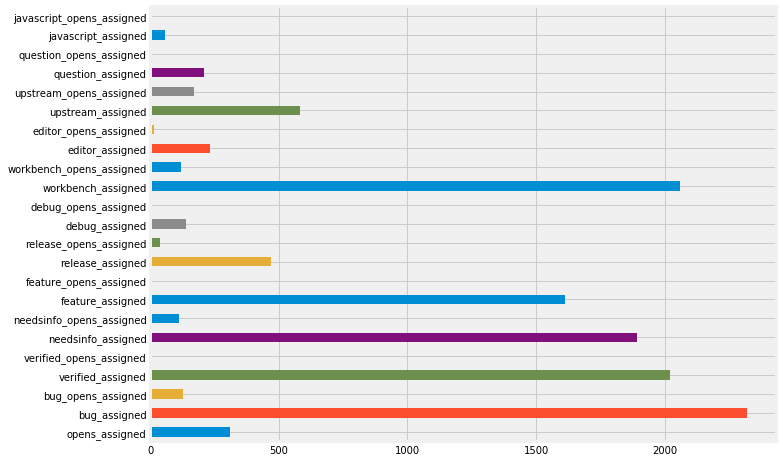

In [28]:
df_total.loc["900690"][assigned_cols].plot.barh(figsize=(10,8))

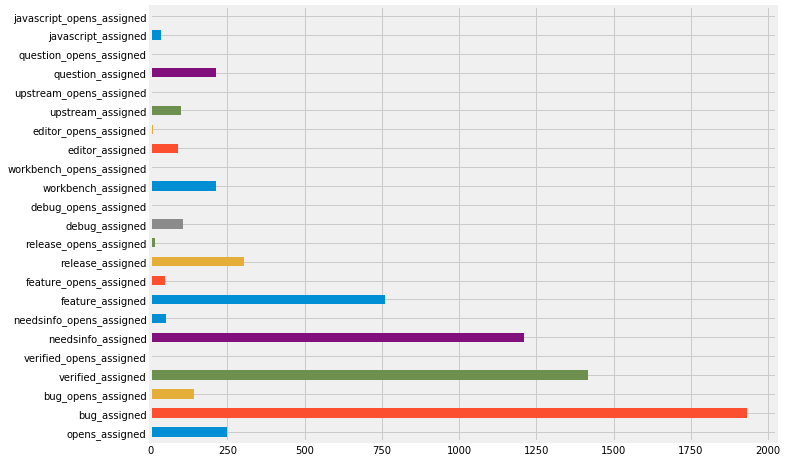

In [29]:
df_total.loc["22350"][assigned_cols].plot.barh(figsize=(10,8))

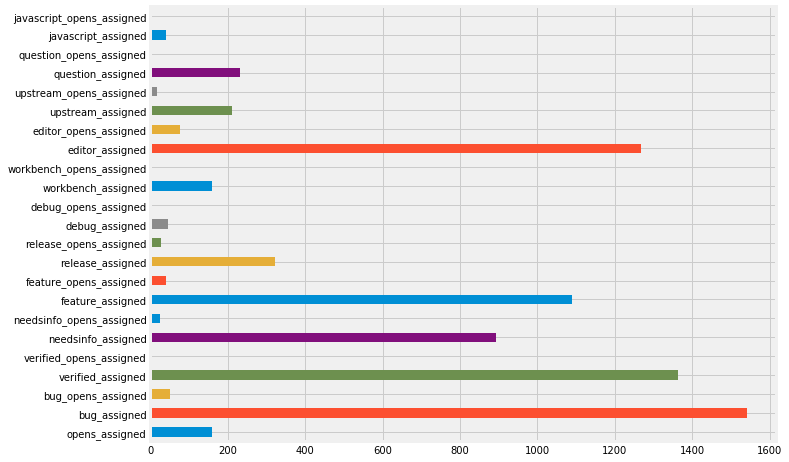

In [30]:
df_total.loc["5047891"][assigned_cols].plot.barh(figsize=(10,8))

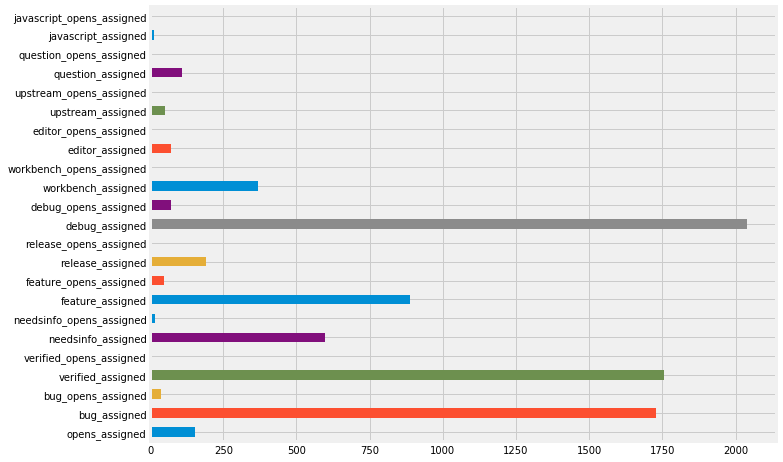

In [31]:
df_total.loc["1926584"][assigned_cols].plot.barh(figsize=(10,8))

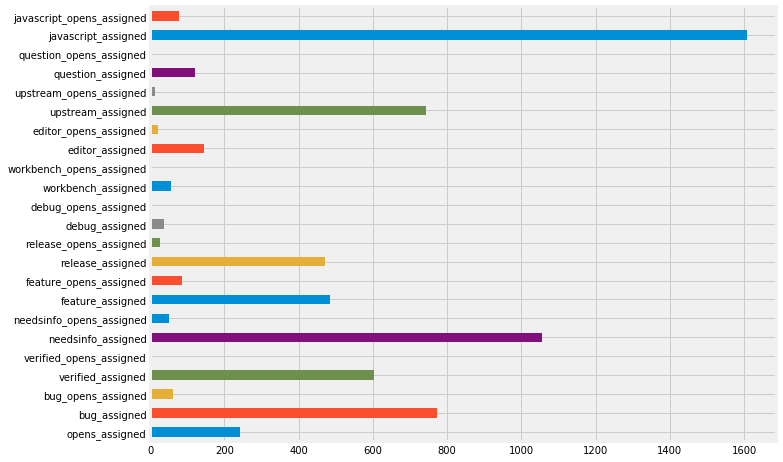

In [32]:
df_total.loc["12821956"][assigned_cols].plot.barh(figsize=(10,8))

### Labels like bug, needs more info, verified, and feature request seem to be very commom labels, they are probably used with other labels to add more information about the issue

## Using % of assignments, % of issues with each label that were assigned to the user, that should remove the noise from the common labels

In [33]:
assigned_user = [column for column in df_total.columns if "assign_user_%" in column]

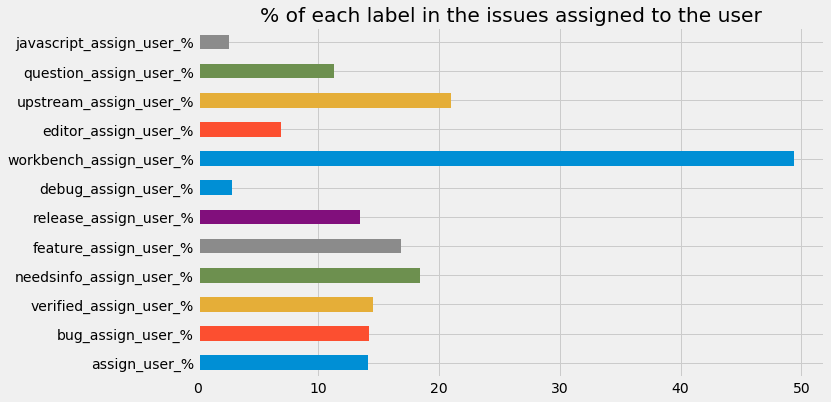

In [89]:
df_total.loc["900690"][assigned_user].plot.barh(figsize=(10,6))
plt.title("% of each label in the issues assigned to the user");

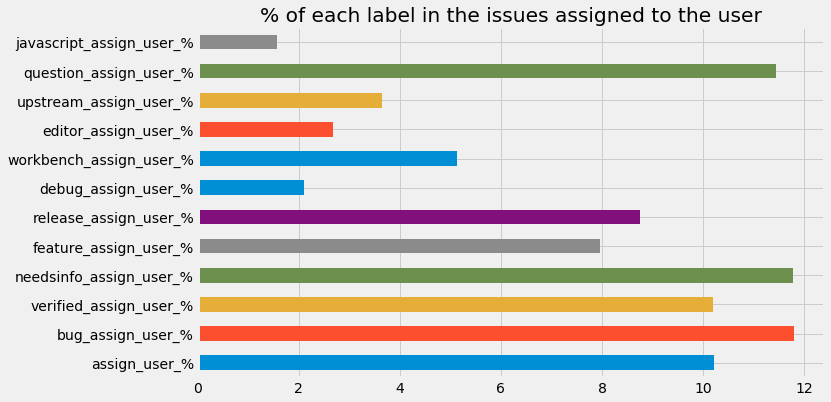

In [90]:
df_total.loc["22350"][assigned_user].plot.barh(figsize=(10,6))
plt.title("% of each label in the issues assigned to the user");

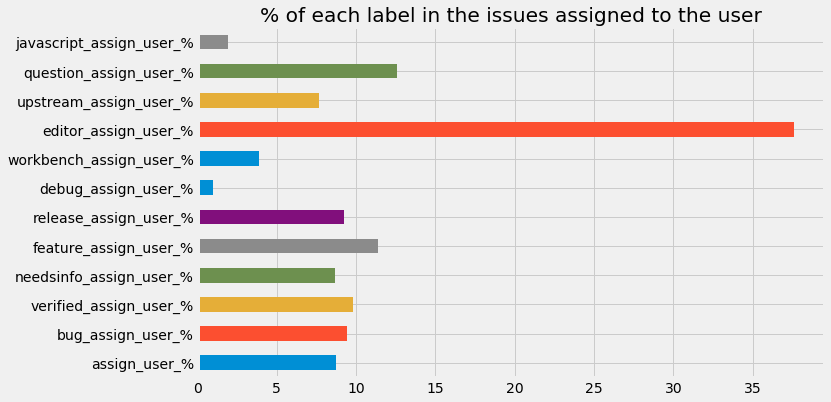

In [91]:
df_total.loc["5047891"][assigned_user].plot.barh(figsize=(10,6))
plt.title("% of each label in the issues assigned to the user");

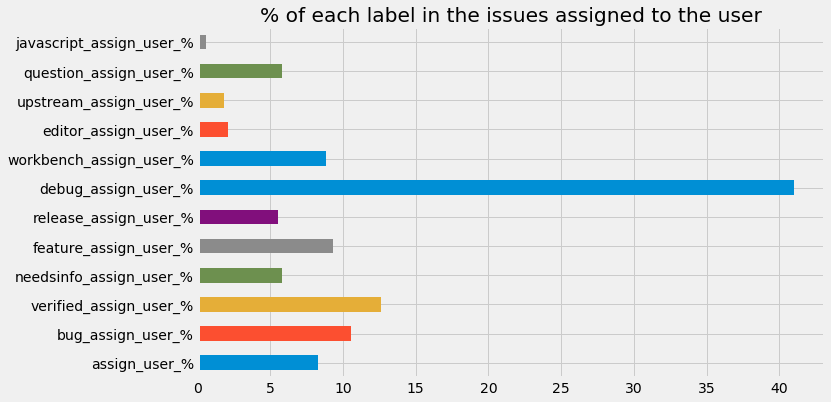

In [92]:
df_total.loc["1926584"][assigned_user].plot.barh(figsize=(10,6))
plt.title("% of each label in the issues assigned to the user");

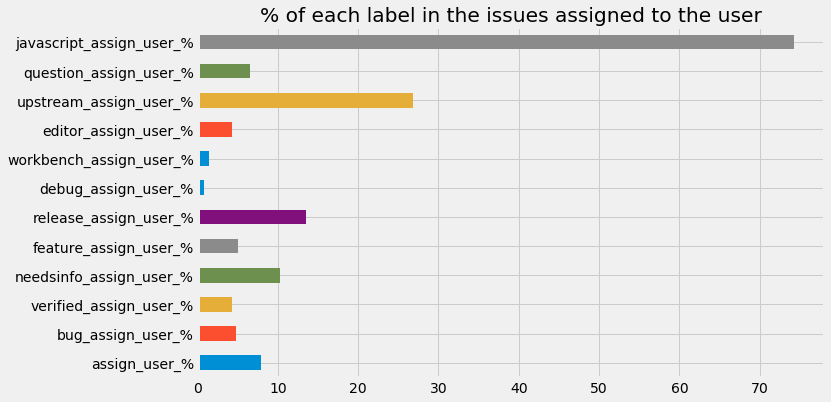

In [93]:
df_total.loc["12821956"][assigned_user].plot.barh(figsize=(10,6))
plt.title("% of each label in the issues assigned to the user");

## Looking at the label:

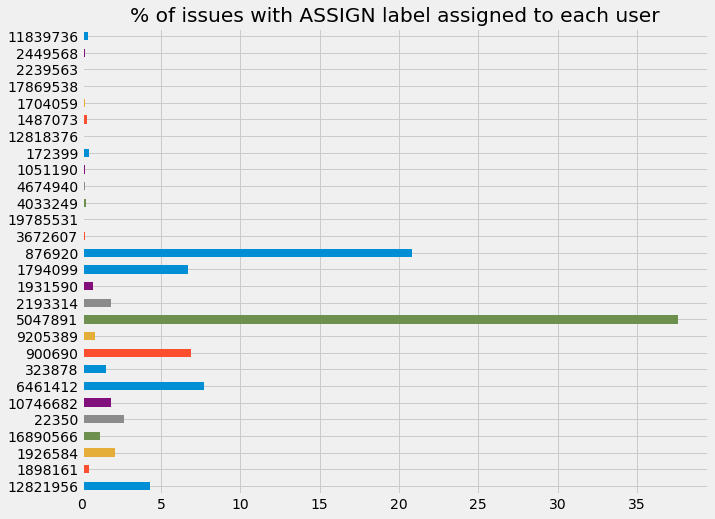

In [87]:
df_total["editor_assign_user_%"].plot.barh(figsize=(10,8))
plt.title("% of issues with ASSIGN label assigned to each user");

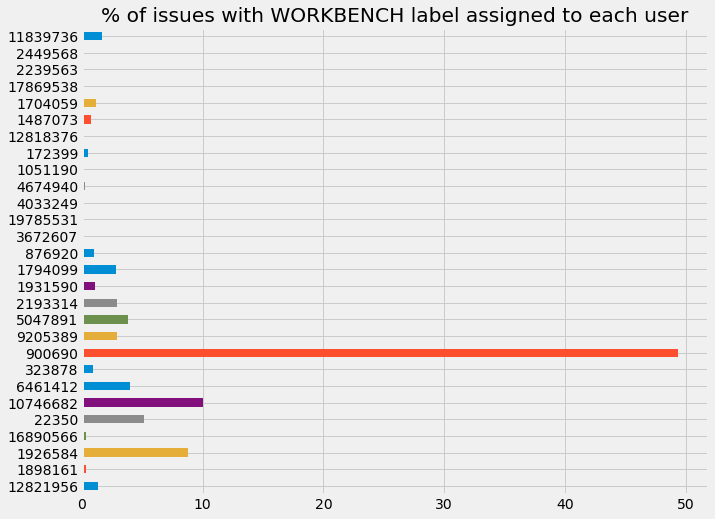

In [88]:
df_total["workbench_assign_user_%"].plot.barh(figsize=(10,8))
plt.title("% of issues with WORKBENCH label assigned to each user");

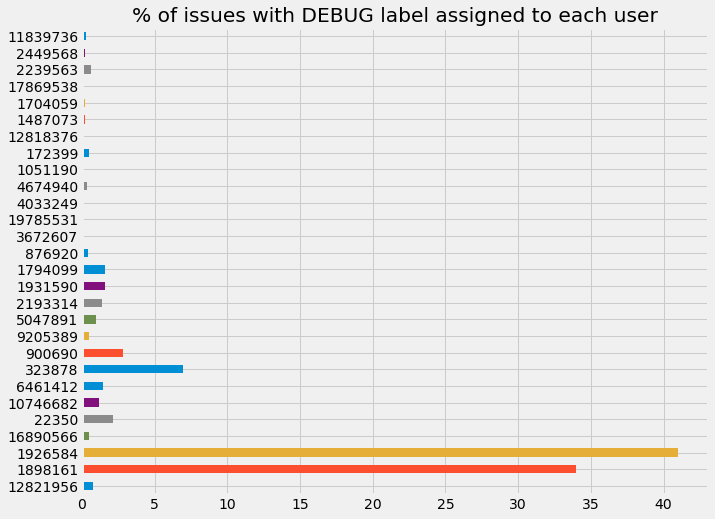

In [86]:
df_total["debug_assign_user_%"].plot.barh(figsize=(10,8))
plt.title("% of issues with DEBUG label assigned to each user");

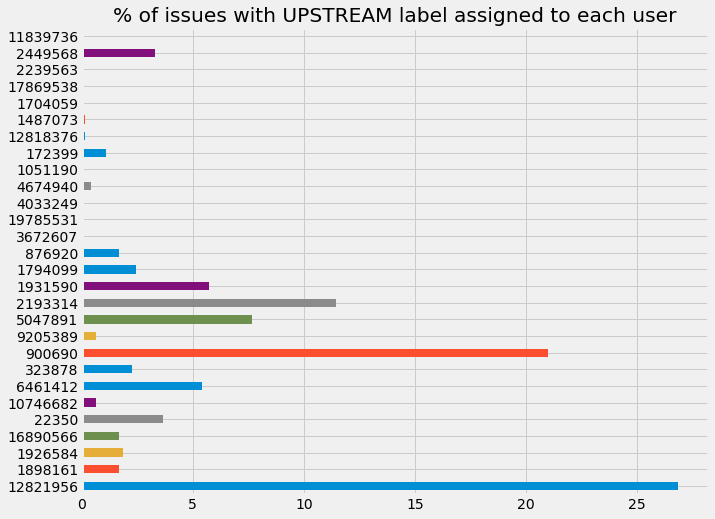

In [85]:
df_total["upstream_assign_user_%"].plot.barh(figsize=(10,8))
plt.title("% of issues with UPSTREAM label assigned to each user");

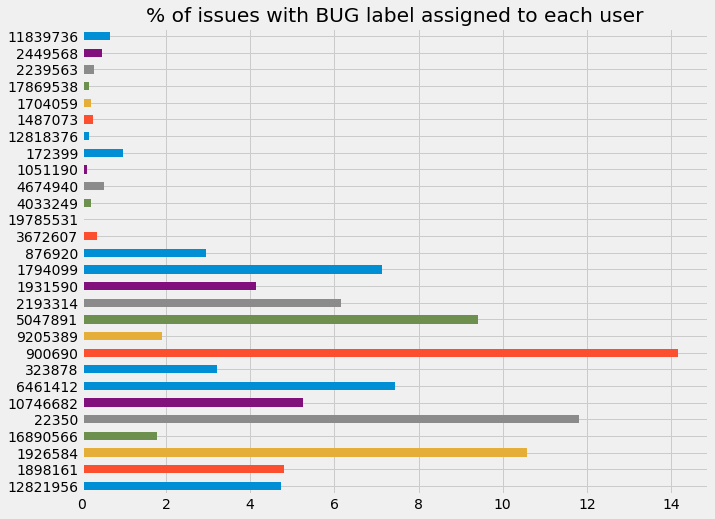

In [82]:
df_total["bug_assign_user_%"].plot.barh(figsize=(10,8))
plt.title("% of issues with BUG label assigned to each user");

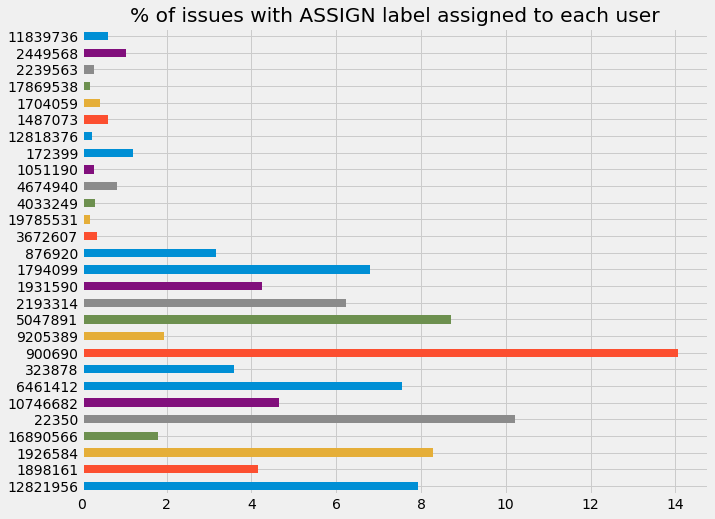

In [83]:
df_total["assign_user_%"].plot.barh(figsize=(10,8))
plt.title("% of issues with ASSIGN label assigned to each user");

# Explore further a specific label: Editor

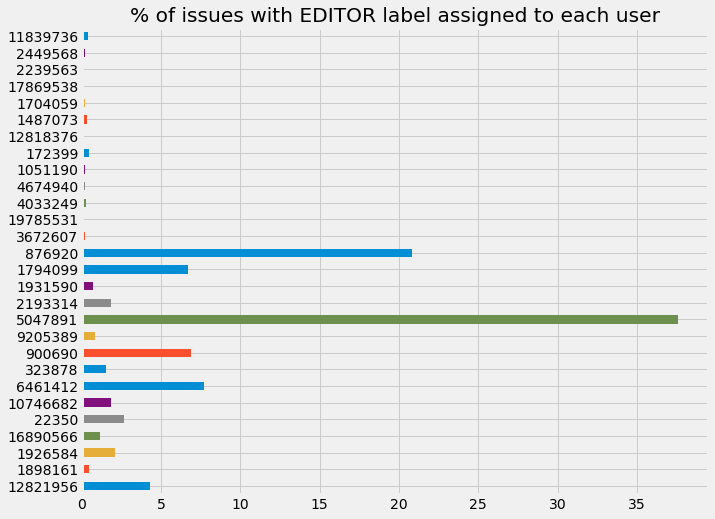

In [84]:
df_total["editor_assign_user_%"].plot.barh(figsize=(10,8));
plt.title("% of issues with EDITOR label assigned to each user");

In [46]:
df_total["editor_assign_user_%"].sort_values(ascending=False)[:5]

5047891    37.614951
876920     20.824681
6461412     7.712845
900690      6.911896
1794099     6.674577
Name: editor_assign_user_%, dtype: float64

*** these are probably the users better suited to deal with the issue, lets explore them***

In [47]:
editor_users = df_total["editor_assign_user_%"].sort_values(ascending=False)[:5].index

In [48]:
editor = df_total.loc[editor_users]

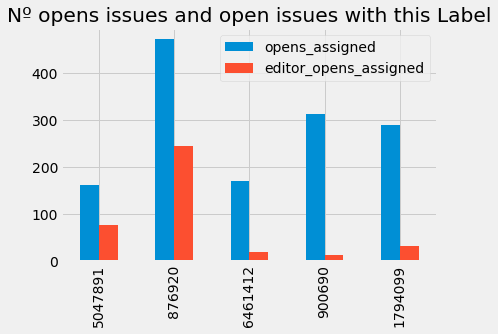

In [75]:
editor[[ "opens_assigned", "editor_opens_assigned"]].plot.bar()
plt.title("Nº opens issues and open issues with this Label");

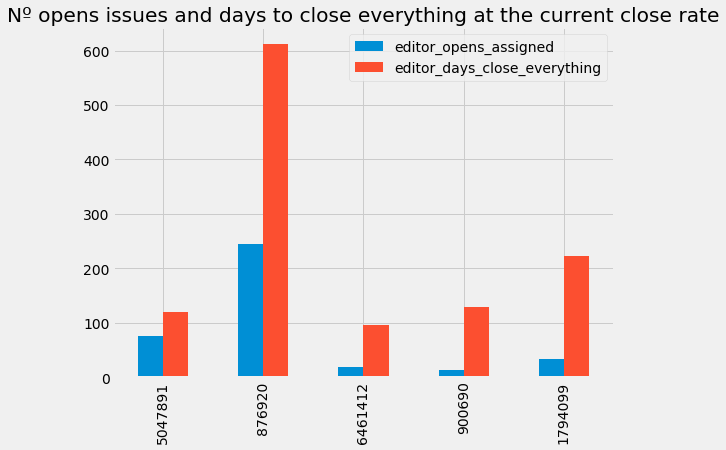

In [74]:
editor[["editor_opens_assigned", "editor_days_close_everything"]].plot.bar(figsize=(8,6))
plt.title("Nº opens issues and days to close everything at the current close rate");

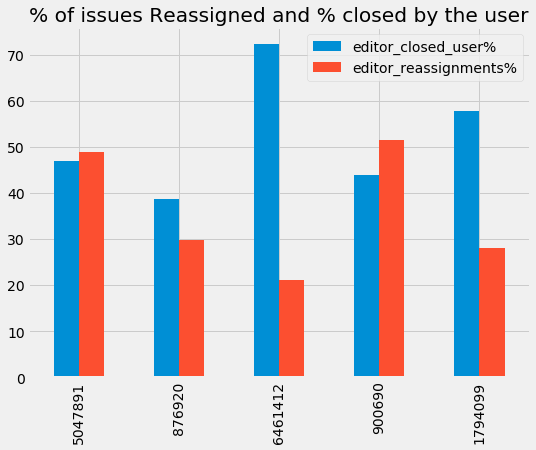

In [71]:
editor[["editor_closed_user%", "editor_reassignments%"]].plot.bar(figsize=(8,6))
plt.title("% of issues Reassigned and % closed by the user");

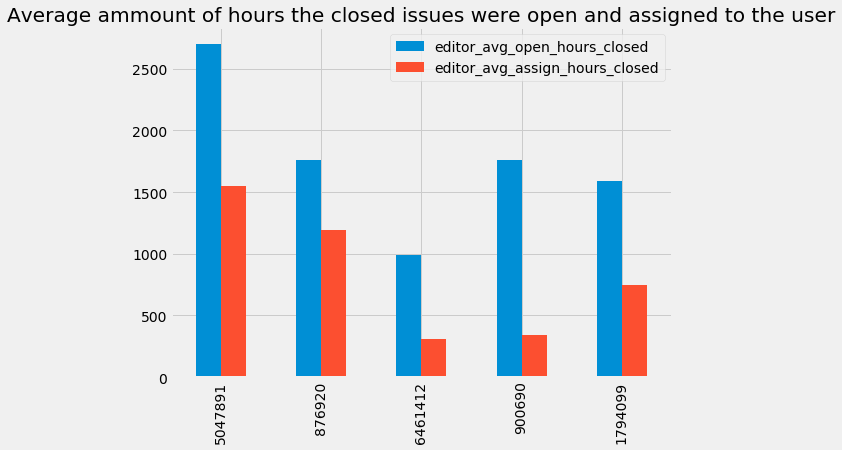

In [99]:
editor[[ 'editor_avg_open_hours_closed',"editor_avg_assign_hours_closed"]].plot.bar(figsize=(8,6))
plt.title("Average ammount of hours the closed issues were open and assigned to the user");

## 5047891 seems to be a good option but he has almost 50% of reassigments, 6461412 is probably a better option with high % of issues closed by him and low average open hours

In [77]:
assigned_user = [column for column in df_total.columns if "assign_user_%" in column]

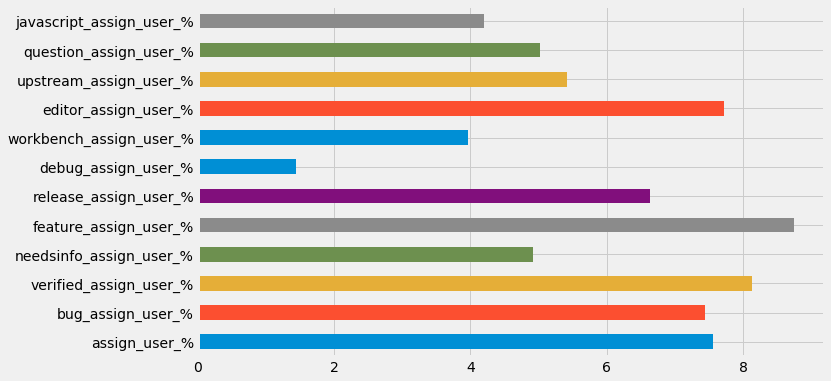

In [78]:
df_total.loc["6461412"][assigned_user].plot.barh(figsize=(10,6))

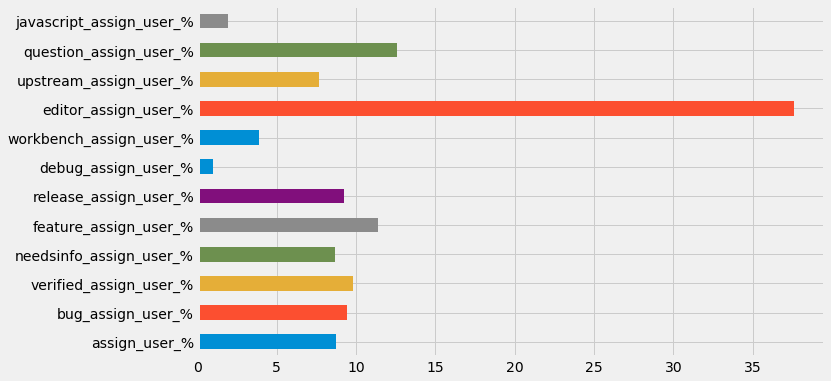

In [79]:
df_total.loc["5047891"][assigned_user].plot.barh(figsize=(10,6))

***5047891 seems to be specialized in solving issues with the "editor" label while 6461412 seems to deal with all kind of issues***

In [98]:
editor_df

,editor_assigned,editor_avg_assign_hours,editor_avg_assign_hours_closed,editor_avg_assign_hours_open,editor_avg_open_hours,editor_avg_open_hours_closed,editor_avg_open_hours_open,editor_close_rate,editor_closed,editor_closed_user,editor_closed_user%,editor_days_close_everything,editor_last_closed,editor_oldest_assignment,editor_opens,editor_opens_assigned,editor_reassignments,editor_reassignments%,editor_assign_user_%
12821956,144,1375.837272,387.660992,4834.454253,1848.093601,979.028862,4889.820191,0.178010,112,102,70.833333,117.970588,2018-06-18 22:52:22,2016-11-22 08:25:31,32,21,21,14.583333,4.271729
1898161,16,91.536892,28.055214,366.624167,219.315313,184.151282,371.692778,0.012552,13,9,56.250000,79.666667,2018-01-16 03:20:30,2016-01-29 09:50:20,3,1,8,50.000000,0.474637
1926584,71,652.542371,122.553616,4303.576019,1435.625473,978.414207,4585.303086,0.053837,62,47,66.197183,37.148936,2018-06-20 14:04:51,2016-01-29 09:49:44,9,2,24,33.802817,2.106200
16890566,39,704.347977,410.654264,6137.681667,1743.268575,1022.176029,15083.480694,0.061983,37,30,76.923077,16.133333,2018-06-22 21:57:41,2017-02-23 09:49:30,2,1,8,20.512821,1.156927
22350,90,1849.685269,374.338464,5906.888981,2545.687858,1237.262008,6143.858947,0.063702,66,53,58.888889,156.981132,2018-05-28 13:05:07,2016-02-15 21:36:22,24,10,29,32.222222,2.669831
10746682,62,2414.593535,622.695249,5453.029758,3139.695927,1696.910142,5586.158780,0.033378,39,25,40.322581,449.400000,2018-06-13 08:41:19,2016-05-24 18:21:03,23,15,23,37.096774,1.839217
6461412,260,939.242176,306.779995,4634.152814,1536.894691,986.287553,4753.599554,0.199575,222,188,72.307692,95.202128,2018-06-22 14:33:28,2015-11-23 14:17:31,38,19,55,21.153846,7.712845
323878,52,1052.346458,197.993860,3371.303512,1258.693595,472.818765,3391.782421,0.045997,38,27,51.923077,239.148148,2018-05-29 18:14:31,2016-10-18 22:50:02,14,11,15,28.846154,1.542569
900690,233,1511.509266,342.734860,5385.779979,2756.599075,1758.352967,6065.600062,0.108165,179,102,43.776824,129.431373,2018-06-19 10:00:08,2015-11-18 17:34:57,54,14,120,51.502146,6.911896
9205389,27,996.666523,1778.927833,536.512810,1585.307840,3343.554167,551.045294,0.009331,10,6,22.222222,1821.833333,2018-06-21 09:32:03,2016-09-16 03:53:35,17,17,4,14.814815,0.800949
